# 基于DDPG算法的电磁式阻尼器控制

本笔记本实现了基于DDPG算法的二自由度电磁阻尼器控制系统。参数来源于MATLAB仿真文件，方法迁移自《数据驱动的动力学系统建模及控制策略研究》。

In [20]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from datetime import datetime
import os

from env import ElectromagneticDamperEnv # 自定义环境
from ddpg_agent import DDPGAgent, ReplayBuffer # DDPG智能体和经验回放缓冲区
from train import train_ddpg # 训练函数
from af import plot_rewards, plot_state_comparison # 绘图函数

# 设置随机种子，保证结果可重现
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei', 'Arial']

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建保存模型的目录
save_model_dir = "./saved_models"
save_plot_dir = "./saved_plots"
os.makedirs(save_model_dir, exist_ok=True)
os.makedirs(save_plot_dir, exist_ok=True)

使用设备: cuda


## 超参数设置

In [21]:
# 控制参数
T = 3  # 系统运行时间
Ts = 0.001  # 采样时间步长

## 系统参数设置

从MATLAB仿真文件中提取二自由度电磁阻尼器系统的参数。

In [22]:
# 系统参数（来自MATLAB文件）
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000.0  # 电磁吸振器刚度
k_M = 200000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 0.2  # 电磁吸振器阻尼
c_M = 1.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

### 无控制输出环境验证

仿真进度: 10001it [00:00, 47097.22it/s]                          
仿真进度: 10001it [00:00, 47097.22it/s]                          


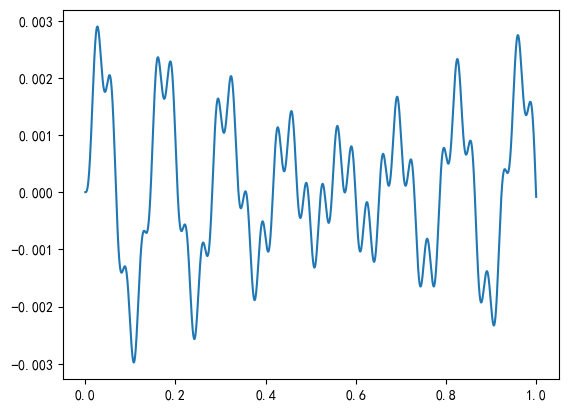

In [23]:
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.0001, T=1)

# 定义正弦扰动函数用于测试
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(2 * np.pi * freq * t)
    return func

# 运行无控制的仿真
results_no_control = rl_env.run_simulation(z_func=sine_disturbance(0.01, 30))
plt.plot(results_no_control['times'], results_no_control['states'][:, 2], label='No Control')

## 初始化环境和DDPG代理

使用从MATLAB文件提取的参数创建电磁阻尼器系统环境和DDPG代理。

In [24]:
# 创建仿真环境
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=Ts, T=T)

# 设置外部扰动函数 - 这里设置为简单的正弦波扰动
# 定义正弦扰动函数用于测试
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(2 * np.pi * freq * t)
    return func

rl_env.set_disturbance(sine_disturbance(0.001, 30)) # 设置扰动函数

agent = DDPGAgent(
    state_dim=1, # 状态维度
    action_dim=1, # 动作维度
    hidden_dim=64, # 隐藏层维度
    action_bound=5.0, # 动作范围
    actor_lr=1e-4, # 调整学习率可能需要
    critic_lr=1e-3,
    gamma=0.99,
    tau=0.005,
    sigma=0.2 # 初始噪声标准差
)

# 创建经验回放池
replay_buffer = ReplayBuffer(capacity=100000, batch_size=64)

## 训练DDPG代理

训练DDPG代理来控制电磁阻尼器系统。

训练轮次:   1%|          | 2/200 [00:53<1:31:33, 27.75s/it]

Episode: 2, Reward: -101.23, Avg Reward: -60.18, Avg Critic Loss: 0.0002, Avg Actor Loss: 0.0260, Epsilon: 0.99


训练轮次:   2%|▏         | 4/200 [01:53<1:35:14, 29.15s/it]

Episode: 4, Reward: -80.48, Avg Reward: -52.21, Avg Critic Loss: 0.0046, Avg Actor Loss: 0.3272, Epsilon: 0.97


训练轮次:   2%|▎         | 5/200 [02:26<1:39:07, 30.50s/it]

已保存模型和检查点: 0502_1918_ep5


训练轮次:   3%|▎         | 6/200 [02:59<1:42:00, 31.55s/it]

Episode: 6, Reward: -14177.97, Avg Reward: -2404.76, Avg Critic Loss: 0.2933, Avg Actor Loss: 2.0242, Epsilon: 0.96


训练轮次:   4%|▍         | 8/200 [04:13<1:51:08, 34.73s/it]

Episode: 8, Reward: -23326.08, Avg Reward: -6626.99, Avg Critic Loss: 63.3733, Avg Actor Loss: 33.1586, Epsilon: 0.94


训练轮次:   5%|▌         | 10/200 [05:36<2:01:05, 38.24s/it]

Episode: 10, Reward: -75133.57, Avg Reward: -19140.62, Avg Critic Loss: 1669.0817, Avg Actor Loss: 139.3931, Epsilon: 0.93
已保存模型和检查点: 0502_1918_ep10


训练轮次:   6%|▌         | 12/200 [06:51<1:57:44, 37.58s/it]

Episode: 12, Reward: -26394.82, Avg Reward: -22911.60, Avg Critic Loss: 7686.8922, Avg Actor Loss: 302.7904, Epsilon: 0.91


训练轮次:   7%|▋         | 14/200 [07:58<1:49:45, 35.41s/it]

Episode: 14, Reward: -6124.74, Avg Reward: -20679.21, Avg Critic Loss: 12032.3921, Avg Actor Loss: 358.5269, Epsilon: 0.89


训练轮次:   8%|▊         | 15/200 [08:32<1:47:57, 35.01s/it]

已保存模型和检查点: 0502_1918_ep15


训练轮次:   8%|▊         | 16/200 [09:07<1:47:50, 35.17s/it]

Episode: 16, Reward: -4617.10, Avg Reward: -18759.36, Avg Critic Loss: 10927.3103, Avg Actor Loss: 353.4145, Epsilon: 0.88


训练轮次:   9%|▉         | 18/200 [10:23<1:50:08, 36.31s/it]

Episode: 18, Reward: -4292.11, Avg Reward: -17148.39, Avg Critic Loss: 13954.8483, Avg Actor Loss: 334.5393, Epsilon: 0.86


训练轮次:  10%|█         | 20/200 [11:51<2:00:42, 40.24s/it]

Episode: 20, Reward: -4872.83, Avg Reward: -15920.70, Avg Critic Loss: 11634.5581, Avg Actor Loss: 306.9113, Epsilon: 0.84
已保存模型和检查点: 0502_1918_ep20


训练轮次:  11%|█         | 22/200 [13:06<1:54:05, 38.46s/it]

Episode: 22, Reward: -3744.26, Avg Reward: -14864.40, Avg Critic Loss: 6289.3903, Avg Actor Loss: 286.0581, Epsilon: 0.82


训练轮次:  12%|█▏        | 24/200 [14:17<1:48:43, 37.07s/it]

Episode: 24, Reward: -3058.41, Avg Reward: -13881.00, Avg Critic Loss: 6874.3406, Avg Actor Loss: 261.3349, Epsilon: 0.81


训练轮次:  12%|█▎        | 25/200 [14:50<1:44:37, 35.87s/it]

已保存模型和检查点: 0502_1918_ep25


训练轮次:  13%|█▎        | 26/200 [15:22<1:40:36, 34.69s/it]

Episode: 26, Reward: -3434.62, Avg Reward: -13051.44, Avg Critic Loss: 9126.8906, Avg Actor Loss: 235.6171, Epsilon: 0.79


训练轮次:  14%|█▍        | 28/200 [16:29<1:37:28, 34.00s/it]

Episode: 28, Reward: -3750.70, Avg Reward: -12384.11, Avg Critic Loss: 11096.4529, Avg Actor Loss: 206.8250, Epsilon: 0.78


训练轮次:  15%|█▌        | 30/200 [17:37<1:36:33, 34.08s/it]

Episode: 30, Reward: -3739.81, Avg Reward: -12593.42, Avg Critic Loss: 7601.4176, Avg Actor Loss: 236.5189, Epsilon: 0.76
已保存模型和检查点: 0502_1918_ep30


训练轮次:  16%|█▌        | 32/200 [18:49<1:38:54, 35.32s/it]

Episode: 32, Reward: -3575.19, Avg Reward: -12001.70, Avg Critic Loss: 5051.4643, Avg Actor Loss: 224.6432, Epsilon: 0.74


训练轮次:  17%|█▋        | 34/200 [20:07<1:43:39, 37.47s/it]

Episode: 34, Reward: -1996.29, Avg Reward: -11554.23, Avg Critic Loss: 3729.8715, Avg Actor Loss: 221.7269, Epsilon: 0.72


训练轮次:  18%|█▊        | 35/200 [20:45<1:43:25, 37.61s/it]

已保存模型和检查点: 0502_1918_ep35


训练轮次:  18%|█▊        | 36/200 [21:23<1:42:54, 37.65s/it]

Episode: 36, Reward: -2045.22, Avg Reward: -11046.97, Avg Critic Loss: 6183.4861, Avg Actor Loss: 228.2803, Epsilon: 0.71


训练轮次:  19%|█▉        | 38/200 [22:33<1:37:42, 36.19s/it]

Episode: 38, Reward: -3538.22, Avg Reward: -10604.59, Avg Critic Loss: 6110.5590, Avg Actor Loss: 228.8171, Epsilon: 0.69


训练轮次:  20%|██        | 40/200 [23:44<1:36:10, 36.07s/it]

Episode: 40, Reward: -873.42, Avg Reward: -10142.65, Avg Critic Loss: 9496.5127, Avg Actor Loss: 222.7912, Epsilon: 0.68
已保存模型和检查点: 0502_1918_ep40


训练轮次:  21%|██        | 42/200 [24:53<1:32:52, 35.27s/it]

Episode: 42, Reward: -1022.71, Avg Reward: -9704.78, Avg Critic Loss: 7059.6058, Avg Actor Loss: 204.9397, Epsilon: 0.66


训练轮次:  22%|██▏       | 44/200 [26:03<1:31:21, 35.14s/it]

Episode: 44, Reward: -655.94, Avg Reward: -9296.48, Avg Critic Loss: 3279.4894, Avg Actor Loss: 136.9049, Epsilon: 0.64


训练轮次:  22%|██▎       | 45/200 [26:39<1:31:20, 35.35s/it]

已保存模型和检查点: 0502_1918_ep45


训练轮次:  23%|██▎       | 46/200 [27:15<1:31:38, 35.70s/it]

Episode: 46, Reward: -213.60, Avg Reward: -8928.98, Avg Critic Loss: 601.7961, Avg Actor Loss: 75.2172, Epsilon: 0.62


训练轮次:  24%|██▍       | 48/200 [28:22<1:27:24, 34.50s/it]

Episode: 48, Reward: -17573.79, Avg Reward: -8975.90, Avg Critic Loss: 397.7303, Avg Actor Loss: 50.8277, Epsilon: 0.61


训练轮次:  25%|██▌       | 50/200 [29:33<1:28:10, 35.27s/it]

Episode: 50, Reward: -1462.90, Avg Reward: -8671.09, Avg Critic Loss: 729.7104, Avg Actor Loss: 55.6038, Epsilon: 0.59
已保存模型和检查点: 0502_1918_ep50


训练轮次:  26%|██▌       | 52/200 [30:50<1:31:10, 36.96s/it]

Episode: 52, Reward: -2015.96, Avg Reward: -8403.62, Avg Critic Loss: 520.4353, Avg Actor Loss: 60.6049, Epsilon: 0.57


训练轮次:  27%|██▋       | 54/200 [32:02<1:28:30, 36.37s/it]

Episode: 54, Reward: -13415.02, Avg Reward: -8614.03, Avg Critic Loss: 565.3968, Avg Actor Loss: 75.5435, Epsilon: 0.56


训练轮次:  28%|██▊       | 55/200 [32:40<1:28:45, 36.73s/it]

已保存模型和检查点: 0502_1918_ep55


训练轮次:  28%|██▊       | 56/200 [33:30<1:38:09, 40.90s/it]

Episode: 56, Reward: -10095.12, Avg Reward: -8681.76, Avg Critic Loss: 384.0774, Avg Actor Loss: 94.0679, Epsilon: 0.54


训练轮次:  29%|██▉       | 58/200 [35:06<1:44:03, 43.97s/it]

Episode: 58, Reward: -9661.89, Avg Reward: -8726.51, Avg Critic Loss: 1011.1787, Avg Actor Loss: 108.0165, Epsilon: 0.53


训练轮次:  30%|███       | 60/200 [36:25<1:37:03, 41.59s/it]

Episode: 60, Reward: -10799.07, Avg Reward: -8781.64, Avg Critic Loss: 913.7123, Avg Actor Loss: 121.3868, Epsilon: 0.51
已保存模型和检查点: 0502_1918_ep60


训练轮次:  31%|███       | 62/200 [37:42<1:32:10, 40.08s/it]

Episode: 62, Reward: -4100.52, Avg Reward: -8664.86, Avg Critic Loss: 542.5221, Avg Actor Loss: 128.7898, Epsilon: 0.49


训练轮次:  32%|███▏      | 64/200 [39:00<1:29:52, 39.65s/it]

Episode: 64, Reward: -2916.05, Avg Reward: -8492.28, Avg Critic Loss: 310.3207, Avg Actor Loss: 114.8603, Epsilon: 0.47


训练轮次:  32%|███▎      | 65/200 [39:36<1:26:51, 38.60s/it]

已保存模型和检查点: 0502_1918_ep65


训练轮次:  33%|███▎      | 66/200 [40:14<1:25:31, 38.29s/it]

Episode: 66, Reward: -4108.02, Avg Reward: -8323.94, Avg Critic Loss: 289.1968, Avg Actor Loss: 117.9890, Epsilon: 0.46


训练轮次:  34%|███▍      | 68/200 [41:30<1:23:58, 38.17s/it]

Episode: 68, Reward: -1693.32, Avg Reward: -8122.24, Avg Critic Loss: 260.5503, Avg Actor Loss: 111.9145, Epsilon: 0.44


训练轮次:  35%|███▌      | 70/200 [42:49<1:23:55, 38.73s/it]

Episode: 70, Reward: -1807.01, Avg Reward: -7936.03, Avg Critic Loss: 256.9657, Avg Actor Loss: 106.3001, Epsilon: 0.43
已保存模型和检查点: 0502_1918_ep70


训练轮次:  36%|███▌      | 72/200 [44:09<1:24:09, 39.45s/it]

Episode: 72, Reward: -1706.56, Avg Reward: -7764.27, Avg Critic Loss: 239.1639, Avg Actor Loss: 104.3627, Epsilon: 0.41


训练轮次:  37%|███▋      | 74/200 [45:29<1:24:03, 40.03s/it]

Episode: 74, Reward: -1868.48, Avg Reward: -7605.62, Avg Critic Loss: 257.9601, Avg Actor Loss: 108.3861, Epsilon: 0.39


训练轮次:  38%|███▊      | 75/200 [46:09<1:23:00, 39.85s/it]

已保存模型和检查点: 0502_1918_ep75


训练轮次:  38%|███▊      | 76/200 [46:49<1:22:30, 39.93s/it]

Episode: 76, Reward: -1856.25, Avg Reward: -7455.05, Avg Critic Loss: 234.3926, Avg Actor Loss: 105.3303, Epsilon: 0.38


训练轮次:  39%|███▉      | 78/200 [48:08<1:20:41, 39.69s/it]

Episode: 78, Reward: -1776.30, Avg Reward: -7309.95, Avg Critic Loss: 187.4325, Avg Actor Loss: 102.1654, Epsilon: 0.36


训练轮次:  40%|████      | 80/200 [49:26<1:18:37, 39.31s/it]

Episode: 80, Reward: -1822.49, Avg Reward: -7173.24, Avg Critic Loss: 168.5942, Avg Actor Loss: 101.1753, Epsilon: 0.34
已保存模型和检查点: 0502_1918_ep80


训练轮次:  41%|████      | 82/200 [50:47<1:18:52, 40.11s/it]

Episode: 82, Reward: -2046.90, Avg Reward: -7044.40, Avg Critic Loss: 133.0705, Avg Actor Loss: 93.2391, Epsilon: 0.32


训练轮次:  42%|████▏     | 84/200 [52:04<1:16:12, 39.42s/it]

Episode: 84, Reward: -1997.06, Avg Reward: -6925.28, Avg Critic Loss: 122.1014, Avg Actor Loss: 92.2848, Epsilon: 0.31


训练轮次:  42%|████▎     | 85/200 [53:00<1:24:54, 44.30s/it]

已保存模型和检查点: 0502_1918_ep85


训练轮次:  43%|████▎     | 86/200 [54:02<1:34:21, 49.66s/it]

Episode: 86, Reward: -8114.68, Avg Reward: -6879.96, Avg Critic Loss: 124.8871, Avg Actor Loss: 95.0027, Epsilon: 0.29


训练轮次:  44%|████▍     | 88/200 [55:31<1:27:06, 46.67s/it]

Episode: 88, Reward: -1831.37, Avg Reward: -7150.23, Avg Critic Loss: 221.1975, Avg Actor Loss: 111.3847, Epsilon: 0.28


训练轮次:  45%|████▌     | 90/200 [56:41<1:14:34, 40.68s/it]

Episode: 90, Reward: -3549.05, Avg Reward: -7067.51, Avg Critic Loss: 257.9516, Avg Actor Loss: 106.3247, Epsilon: 0.26
已保存模型和检查点: 0502_1918_ep90


训练轮次:  46%|████▌     | 92/200 [57:54<1:09:05, 38.39s/it]

Episode: 92, Reward: -4100.33, Avg Reward: -6996.69, Avg Critic Loss: 258.1028, Avg Actor Loss: 94.5395, Epsilon: 0.24


训练轮次:  47%|████▋     | 94/200 [59:04<1:05:20, 36.99s/it]

Episode: 94, Reward: -617.77, Avg Reward: -6896.64, Avg Critic Loss: 196.7125, Avg Actor Loss: 86.3557, Epsilon: 0.22


训练轮次:  48%|████▊     | 95/200 [59:46<1:07:11, 38.39s/it]

已保存模型和检查点: 0502_1918_ep95


训练轮次:  48%|████▊     | 96/200 [1:00:22<1:05:30, 37.79s/it]

Episode: 96, Reward: -674.11, Avg Reward: -6847.91, Avg Critic Loss: 206.5725, Avg Actor Loss: 81.0496, Epsilon: 0.21


训练轮次:  49%|████▉     | 98/200 [1:01:36<1:03:17, 37.23s/it]

Episode: 98, Reward: -2544.25, Avg Reward: -6741.75, Avg Critic Loss: 256.2729, Avg Actor Loss: 78.5931, Epsilon: 0.19


训练轮次:  50%|█████     | 100/200 [1:03:15<1:12:59, 43.79s/it]

Episode: 100, Reward: -14305.11, Avg Reward: -6845.83, Avg Critic Loss: 252.8605, Avg Actor Loss: 85.5702, Epsilon: 0.18
已保存模型和检查点: 0502_1918_ep100


训练轮次:  51%|█████     | 102/200 [1:04:48<1:13:42, 45.13s/it]

Episode: 102, Reward: -14652.12, Avg Reward: -7136.34, Avg Critic Loss: 320.9972, Avg Actor Loss: 103.9170, Epsilon: 0.16


训练轮次:  52%|█████▏    | 104/200 [1:06:09<1:08:09, 42.60s/it]

Episode: 104, Reward: -14840.29, Avg Reward: -7429.50, Avg Critic Loss: 386.4989, Avg Actor Loss: 123.8923, Epsilon: 0.14


训练轮次:  52%|█████▎    | 105/200 [1:06:45<1:04:07, 40.50s/it]

已保存模型和检查点: 0502_1918_ep105


训练轮次:  53%|█████▎    | 106/200 [1:07:21<1:01:40, 39.36s/it]

Episode: 106, Reward: -14454.68, Avg Reward: -7589.25, Avg Critic Loss: 435.6027, Avg Actor Loss: 144.2753, Epsilon: 0.12


训练轮次:  54%|█████▍    | 108/200 [1:08:33<57:36, 37.57s/it]  

Episode: 108, Reward: -8071.07, Avg Reward: -7384.83, Avg Critic Loss: 508.8610, Avg Actor Loss: 160.3618, Epsilon: 0.11


训练轮次:  55%|█████▌    | 110/200 [1:09:42<53:57, 35.97s/it]

Episode: 110, Reward: -1180.00, Avg Reward: -6030.32, Avg Critic Loss: 448.4949, Avg Actor Loss: 166.9653, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep110


训练轮次:  56%|█████▌    | 112/200 [1:10:53<52:12, 35.60s/it]

Episode: 112, Reward: -589.86, Avg Reward: -5214.46, Avg Critic Loss: 463.8165, Avg Actor Loss: 165.6074, Epsilon: 0.10


训练轮次:  57%|█████▋    | 114/200 [1:12:03<50:38, 35.33s/it]

Episode: 114, Reward: -1261.21, Avg Reward: -5095.21, Avg Critic Loss: 444.7375, Avg Actor Loss: 163.7680, Epsilon: 0.10


训练轮次:  57%|█████▊    | 115/200 [1:12:36<49:12, 34.74s/it]

已保存模型和检查点: 0502_1918_ep115


训练轮次:  58%|█████▊    | 116/200 [1:13:09<47:36, 34.00s/it]

Episode: 116, Reward: -1521.70, Avg Reward: -5015.73, Avg Critic Loss: 461.1010, Avg Actor Loss: 161.1396, Epsilon: 0.10


训练轮次:  59%|█████▉    | 118/200 [1:14:15<46:01, 33.68s/it]

Episode: 118, Reward: -1223.87, Avg Reward: -4952.22, Avg Critic Loss: 454.4814, Avg Actor Loss: 159.9082, Epsilon: 0.10


训练轮次:  60%|██████    | 120/200 [1:15:26<46:05, 34.57s/it]

Episode: 120, Reward: -1957.10, Avg Reward: -4889.13, Avg Critic Loss: 466.0596, Avg Actor Loss: 148.7518, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep120


训练轮次:  61%|██████    | 122/200 [1:16:36<45:14, 34.80s/it]

Episode: 122, Reward: -11046.70, Avg Reward: -5010.85, Avg Critic Loss: 270.8854, Avg Actor Loss: 126.2780, Epsilon: 0.10


训练轮次:  62%|██████▏   | 124/200 [1:17:48<44:56, 35.48s/it]

Episode: 124, Reward: -16036.29, Avg Reward: -5245.95, Avg Critic Loss: 366.8163, Avg Actor Loss: 144.2852, Epsilon: 0.10


训练轮次:  62%|██████▎   | 125/200 [1:18:29<46:24, 37.13s/it]

已保存模型和检查点: 0502_1918_ep125


训练轮次:  63%|██████▎   | 126/200 [1:19:03<44:42, 36.25s/it]

Episode: 126, Reward: -1916.98, Avg Reward: -5233.97, Avg Critic Loss: 437.5066, Avg Actor Loss: 148.0602, Epsilon: 0.10


训练轮次:  64%|██████▍   | 128/200 [1:20:16<43:44, 36.46s/it]

Episode: 128, Reward: -2330.86, Avg Reward: -5206.55, Avg Critic Loss: 479.5249, Avg Actor Loss: 150.7700, Epsilon: 0.10


训练轮次:  65%|██████▌   | 130/200 [1:21:28<42:10, 36.14s/it]

Episode: 130, Reward: -2436.12, Avg Reward: -4949.91, Avg Critic Loss: 525.1410, Avg Actor Loss: 147.5510, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep130


训练轮次:  66%|██████▌   | 132/200 [1:22:36<39:40, 35.01s/it]

Episode: 132, Reward: -6029.65, Avg Reward: -4978.97, Avg Critic Loss: 419.4767, Avg Actor Loss: 148.3657, Epsilon: 0.10


训练轮次:  67%|██████▋   | 134/200 [1:23:42<37:29, 34.08s/it]

Episode: 134, Reward: -1522.63, Avg Reward: -4920.27, Avg Critic Loss: 454.1189, Avg Actor Loss: 137.2070, Epsilon: 0.10


训练轮次:  68%|██████▊   | 135/200 [1:24:16<36:47, 33.96s/it]

已保存模型和检查点: 0502_1918_ep135


训练轮次:  68%|██████▊   | 136/200 [1:24:53<37:05, 34.77s/it]

Episode: 136, Reward: -1674.98, Avg Reward: -4895.94, Avg Critic Loss: 368.9483, Avg Actor Loss: 121.6934, Epsilon: 0.10


训练轮次:  69%|██████▉   | 138/200 [1:26:06<36:52, 35.68s/it]

Episode: 138, Reward: -1366.09, Avg Reward: -4871.87, Avg Critic Loss: 262.6451, Avg Actor Loss: 107.5548, Epsilon: 0.10


训练轮次:  70%|███████   | 140/200 [1:27:28<38:40, 38.68s/it]

Episode: 140, Reward: -1577.48, Avg Reward: -4880.42, Avg Critic Loss: 269.0524, Avg Actor Loss: 90.9950, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep140


训练轮次:  71%|███████   | 142/200 [1:28:54<39:33, 40.93s/it]

Episode: 142, Reward: -1109.41, Avg Reward: -4920.54, Avg Critic Loss: 209.6968, Avg Actor Loss: 82.2075, Epsilon: 0.10


训练轮次:  72%|███████▏  | 144/200 [1:30:13<37:45, 40.45s/it]

Episode: 144, Reward: -7004.67, Avg Reward: -5021.85, Avg Critic Loss: 182.5303, Avg Actor Loss: 85.3958, Epsilon: 0.10


训练轮次:  72%|███████▎  | 145/200 [1:30:52<36:32, 39.87s/it]

已保存模型和检查点: 0502_1918_ep145


训练轮次:  73%|███████▎  | 146/200 [1:31:29<35:13, 39.13s/it]

Episode: 146, Reward: -5127.71, Avg Reward: -5128.55, Avg Critic Loss: 226.7783, Avg Actor Loss: 93.6646, Epsilon: 0.10


训练轮次:  74%|███████▍  | 148/200 [1:32:40<32:26, 37.44s/it]

Episode: 148, Reward: -9861.59, Avg Reward: -5074.15, Avg Critic Loss: 224.6389, Avg Actor Loss: 101.4247, Epsilon: 0.10


训练轮次:  75%|███████▌  | 150/200 [1:33:56<31:24, 37.70s/it]

Episode: 150, Reward: -21207.37, Avg Reward: -5346.65, Avg Critic Loss: 294.9407, Avg Actor Loss: 114.1503, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep150


训练轮次:  76%|███████▌  | 152/200 [1:35:09<29:35, 37.00s/it]

Episode: 152, Reward: -15996.31, Avg Reward: -5729.44, Avg Critic Loss: 541.9006, Avg Actor Loss: 145.0648, Epsilon: 0.10


训练轮次:  77%|███████▋  | 154/200 [1:36:30<29:45, 38.81s/it]

Episode: 154, Reward: -15252.27, Avg Reward: -5999.03, Avg Critic Loss: 826.6845, Avg Actor Loss: 182.9018, Epsilon: 0.10


训练轮次:  78%|███████▊  | 155/200 [1:37:05<28:22, 37.84s/it]

已保存模型和检查点: 0502_1918_ep155


训练轮次:  78%|███████▊  | 156/200 [1:37:40<26:58, 36.79s/it]

Episode: 156, Reward: -5525.67, Avg Reward: -5908.34, Avg Critic Loss: 848.1250, Avg Actor Loss: 190.0187, Epsilon: 0.10


训练轮次:  79%|███████▉  | 158/200 [1:38:51<25:15, 36.07s/it]

Episode: 158, Reward: -3875.27, Avg Reward: -5791.46, Avg Critic Loss: 671.0428, Avg Actor Loss: 159.5141, Epsilon: 0.10


训练轮次:  80%|████████  | 160/200 [1:40:01<23:44, 35.60s/it]

Episode: 160, Reward: -10491.81, Avg Reward: -5858.08, Avg Critic Loss: 835.8389, Avg Actor Loss: 146.5266, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep160


训练轮次:  81%|████████  | 162/200 [1:41:13<22:48, 36.03s/it]

Episode: 162, Reward: -10003.61, Avg Reward: -5929.13, Avg Critic Loss: 944.8365, Avg Actor Loss: 158.9038, Epsilon: 0.10


训练轮次:  82%|████████▏ | 164/200 [1:42:28<22:01, 36.71s/it]

Episode: 164, Reward: -11816.44, Avg Reward: -6112.82, Avg Critic Loss: 863.9585, Avg Actor Loss: 173.3758, Epsilon: 0.10


训练轮次:  82%|████████▎ | 165/200 [1:43:08<22:07, 37.91s/it]

已保存模型和检查点: 0502_1918_ep165


训练轮次:  83%|████████▎ | 166/200 [1:43:44<21:06, 37.26s/it]

Episode: 166, Reward: -20635.16, Avg Reward: -6504.92, Avg Critic Loss: 1212.1030, Avg Actor Loss: 203.8800, Epsilon: 0.10


训练轮次:  84%|████████▍ | 168/200 [1:44:53<19:01, 35.67s/it]

Episode: 168, Reward: -19023.19, Avg Reward: -6847.62, Avg Critic Loss: 1093.2534, Avg Actor Loss: 235.0536, Epsilon: 0.10


训练轮次:  85%|████████▌ | 170/200 [1:46:02<17:39, 35.33s/it]

Episode: 170, Reward: -28782.73, Avg Reward: -7398.11, Avg Critic Loss: 1389.8181, Avg Actor Loss: 266.9334, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep170


训练轮次:  86%|████████▌ | 172/200 [1:47:17<16:55, 36.26s/it]

Episode: 172, Reward: -32205.56, Avg Reward: -7960.83, Avg Critic Loss: 1796.5581, Avg Actor Loss: 312.1466, Epsilon: 0.10


训练轮次:  87%|████████▋ | 174/200 [1:48:24<15:05, 34.82s/it]

Episode: 174, Reward: -28227.73, Avg Reward: -8577.74, Avg Critic Loss: 2342.7693, Avg Actor Loss: 364.7755, Epsilon: 0.10


训练轮次:  88%|████████▊ | 175/200 [1:48:54<14:00, 33.60s/it]

已保存模型和检查点: 0502_1918_ep175


训练轮次:  88%|████████▊ | 176/200 [1:49:26<13:09, 32.88s/it]

Episode: 176, Reward: -29228.17, Avg Reward: -9142.45, Avg Critic Loss: 2961.6000, Avg Actor Loss: 411.7264, Epsilon: 0.10


训练轮次:  89%|████████▉ | 178/200 [1:50:26<11:33, 31.51s/it]

Episode: 178, Reward: -27053.86, Avg Reward: -9680.75, Avg Critic Loss: 3085.7082, Avg Actor Loss: 465.3122, Epsilon: 0.10


训练轮次:  90%|█████████ | 180/200 [1:51:28<10:23, 31.17s/it]

Episode: 180, Reward: -17631.07, Avg Reward: -10034.56, Avg Critic Loss: 3540.7965, Avg Actor Loss: 503.3918, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep180


训练轮次:  91%|█████████ | 182/200 [1:52:34<09:36, 32.02s/it]

Episode: 182, Reward: -27880.70, Avg Reward: -10460.02, Avg Critic Loss: 3805.9584, Avg Actor Loss: 530.8169, Epsilon: 0.10


训练轮次:  92%|█████████▏| 184/200 [1:53:35<08:21, 31.33s/it]

Episode: 184, Reward: -12708.35, Avg Reward: -10745.08, Avg Critic Loss: 4274.6794, Avg Actor Loss: 552.2712, Epsilon: 0.10


训练轮次:  92%|█████████▎| 185/200 [1:54:06<07:44, 30.96s/it]

已保存模型和检查点: 0502_1918_ep185


训练轮次:  93%|█████████▎| 186/200 [1:54:36<07:12, 30.86s/it]

Episode: 186, Reward: -14405.77, Avg Reward: -10920.98, Avg Critic Loss: 4004.0982, Avg Actor Loss: 537.8867, Epsilon: 0.10


训练轮次:  94%|█████████▍| 188/200 [1:55:38<06:10, 30.88s/it]

Episode: 188, Reward: -13675.74, Avg Reward: -10815.07, Avg Critic Loss: 4307.3377, Avg Actor Loss: 520.5476, Epsilon: 0.10


训练轮次:  95%|█████████▌| 190/200 [1:56:39<05:06, 30.61s/it]

Episode: 190, Reward: -10074.49, Avg Reward: -10972.72, Avg Critic Loss: 3939.8816, Avg Actor Loss: 530.1023, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep190


训练轮次:  96%|█████████▌| 192/200 [1:57:40<04:04, 30.50s/it]

Episode: 192, Reward: -12024.27, Avg Reward: -11158.68, Avg Critic Loss: 3866.1095, Avg Actor Loss: 542.3158, Epsilon: 0.10


训练轮次:  97%|█████████▋| 194/200 [1:58:40<03:02, 30.35s/it]

Episode: 194, Reward: -14180.53, Avg Reward: -11502.22, Avg Critic Loss: 3903.8177, Avg Actor Loss: 548.9647, Epsilon: 0.10


训练轮次:  98%|█████████▊| 195/200 [1:59:10<02:31, 30.31s/it]

已保存模型和检查点: 0502_1918_ep195


训练轮次:  98%|█████████▊| 196/200 [1:59:41<02:01, 30.40s/it]

Episode: 196, Reward: -14585.34, Avg Reward: -11698.88, Avg Critic Loss: 3484.5985, Avg Actor Loss: 557.8145, Epsilon: 0.10


训练轮次:  99%|█████████▉| 198/200 [2:00:41<01:00, 30.17s/it]

Episode: 198, Reward: -13592.68, Avg Reward: -11946.71, Avg Critic Loss: 3617.5109, Avg Actor Loss: 571.1525, Epsilon: 0.10


训练轮次: 100%|██████████| 200/200 [2:01:42<00:00, 36.51s/it]

Episode: 200, Reward: -14623.75, Avg Reward: -11978.19, Avg Critic Loss: 3175.7753, Avg Actor Loss: 560.4606, Epsilon: 0.10
已保存模型和检查点: 0502_1918_ep200
已保存最终模型和检查点: 0502_1918_ep200_final


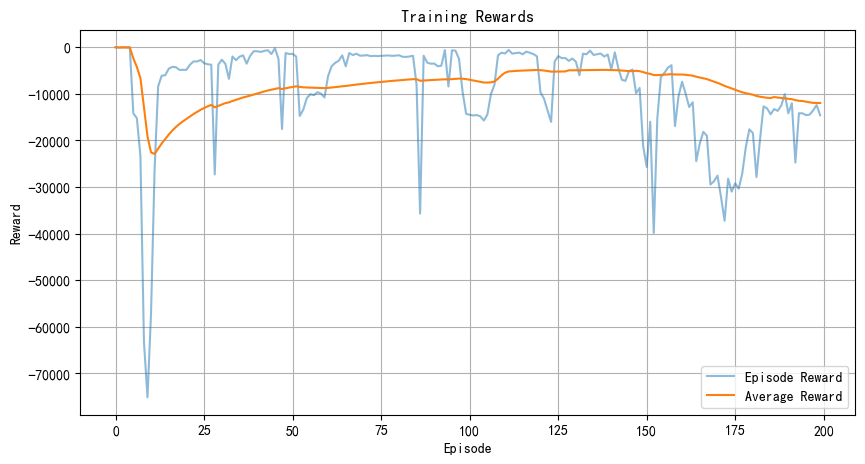

In [25]:
# 获取当前时间，用于命名模型文件
current_time = datetime.now().strftime("%m%d_%H%M")
def r_func(obs:np.ndarray, action:np.ndarray, next_obs:np.ndarray)-> float:
    """自定义奖励函数"""
    sum_next_obs = np.sum(next_obs**2) # 计算下一个状态的平方和
    sum_action = np.sum(action**2) # 计算动作的平方和
    # 奖励函数：负的状态平方和和动作平方和之和
    reward:float = - (10 * sum_next_obs + 0.001 * sum_action) # 奖励越大越好
    return reward

# 查找保存的所有检查点文件
def find_checkpoint_files(directory):
    """查找目录中所有检查点文件"""
    checkpoint_files = []
    for filename in os.listdir(directory):
        if filename.endswith('_checkpoint.pth'):
            checkpoint_files.append(os.path.join(directory, filename))
    
    # 按文件修改时间排序
    checkpoint_files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    return checkpoint_files

# 是否加载先前的训练模型
load_previous_model = input("是否加载先前的训练模型? (y/n): ").strip().lower() == 'y'

start_episode = 0
initial_episode_rewards = None
previous_model_path = None

if load_previous_model:
    checkpoint_files = find_checkpoint_files(save_model_dir)
    
    if checkpoint_files:
        print("\n找到以下检查点文件:")
        for i, file in enumerate(checkpoint_files):
            file_name = os.path.basename(file)
            file_time = os.path.getmtime(file)
            print(f"{i+1}. {file_name} (修改时间: {datetime.fromtimestamp(file_time).strftime('%Y-%m-%d %H:%M:%S')})")
        
        choice = input("请选择要加载的检查点文件编号 (输入数字，直接回车取最新): ")
        
        if choice.strip():
            selected_index = int(choice) - 1
            if 0 <= selected_index < len(checkpoint_files):
                previous_model_path = checkpoint_files[selected_index]
        else:
            # 默认选择最新的检查点
            previous_model_path = checkpoint_files[0]
        
        print(f"加载模型: {os.path.basename(previous_model_path)}")
        
        # 加载模型并获取训练状态
        episode_rewards, current_episode = agent.load_checkpoint(previous_model_path)
        start_episode = current_episode
        initial_episode_rewards = episode_rewards
        print(f"继续从第 {start_episode} 轮训练，已完成 {len(episode_rewards)} 轮")
    else:
        print("未找到可加载的检查点文件，将从零开始训练")

# 训练DDPG代理
training_results = train_ddpg(
    env=rl_env,
    agent=agent,
    replay_buffer=replay_buffer,
    n_episodes=200,  # 训练轮数
    batch_size=64, # 批次大小
    min_buffer_size=1000, # 最小回放池大小
    print_interval=2, # 打印信息的间隔
    save_interval=5, # 保存模型的间隔
    save_path=save_model_dir, # 保存模型的路径
    r_func=r_func, # 奖励函数
    start_episode=start_episode,
    initial_episode_rewards=initial_episode_rewards,
    load_previous=load_previous_model,
    previous_model=previous_model_path
)

# 绘制训练奖励曲线
plot_rewards(training_results['episode_rewards'], training_results['avg_rewards'], save_dir=save_plot_dir)

## 测试与结果对比

测试不同控制策略（无控制、LQR控制和DDPG控制）的效果，并进行对比分析。

In [26]:
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.001, T=1)

# 定义正弦扰动函数用于测试
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(2 * np.pi * freq * t)
    return func

仿真进度: 100%|██████████| 1000/1000 [00:00<00:00, 1393.28it/s]



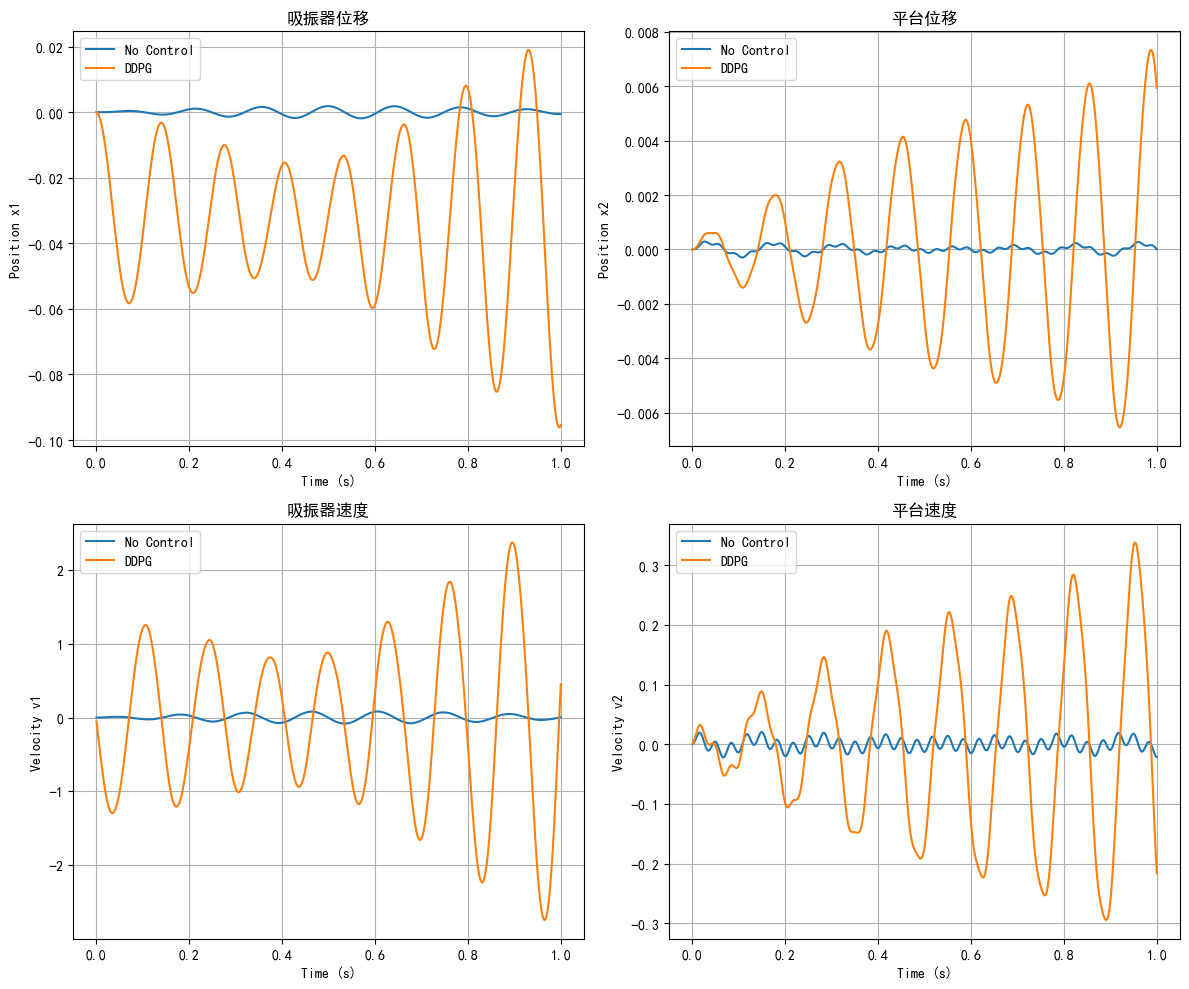

ValueError: x and y must have same first dimension, but have shapes (999,) and (1000,)

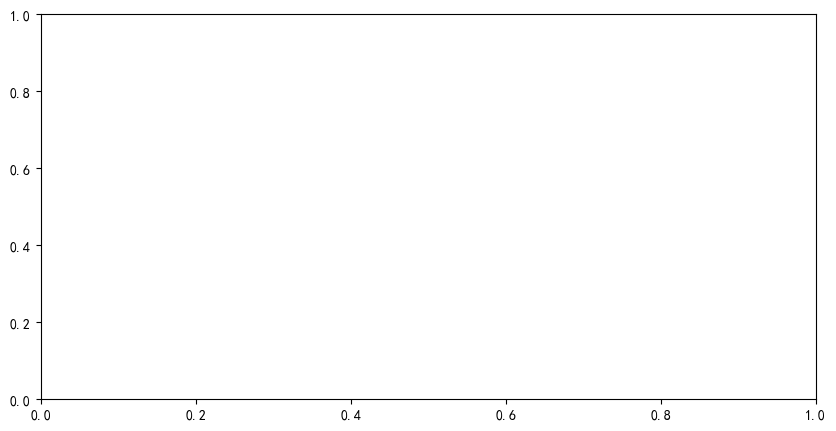

In [30]:
# --- 运行仿真 ---
# 注意：run_simulation现在需要 disturbance_func 参数

# 运行无控制的仿真
results_no_control = rl_env.run_simulation(z_func=sine_disturbance(0.001, 30))

# 加载训练好的DDPG模型 (如果需要)
agent.load(f"{save_model_dir}/ddpg_agent_0502_1918_ep5.pth")

# 运行DDPG控制的仿真 (控制器基于观测值)
results_ddpg = rl_env.run_simulation(z_func=sine_disturbance(0.001, 30), controller=agent.actor)

# --- 绘制对比结果 ---
# plot_state_comparison 使用的是 'states' (完整状态) 进行绘图
plot_state_comparison(results_no_control, results_ddpg)

# --- 打印总奖励值的对比 ---
# 注意：奖励现在基于观测到的加速度计算
# print(f"无控制总奖励: {results_no_control['total_reward']:.2f}")
# print(f"DDPG控制总奖励: {results_ddpg['total_reward']:.2f}")